# 车辆检测及型号识别 —— 热图法
1）对图片中的汽车生成热图     
2）根据热图检测出汽车的位置     
3）对汽车分类     
4）在图片中标记出汽车位置和型号

In [1]:
import tensorflow as tf
import numpy as np
import vgg
import cv2

from scipy.misc import imread, imresize
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
from PIL import Image,ImageDraw, ImageFont


C:\Users\l\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1 生成热图

C:\Users\l\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\l\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
C:\Users\l\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\l\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2

432 320


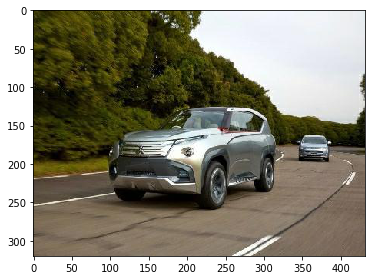

In [2]:
# 读取图片，并转化为四维张量
image_path = './test_image/test1.jpg'      # 修改读取图片的路径
test_image = imread(image_path,mode='RGB')
img_width = test_image.shape[1]
img_height = test_image.shape[0]
image = imresize(test_image,(224,224))
x = np.expand_dims(image,axis=0)
x = x[:,:,:,::-1]

print(img_width,img_height)
io.imshow(test_image)

In [3]:
# 加载模型
sess = tf.Session()
imgs = tf.placeholder(tf.float32,[None,224,224,3])
vgg_load = vgg.vgg16(imgs, 'vgg16_weights.npz', sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


In [4]:
# 检测出图片中车辆的概率
prob = sess.run(vgg_load.probs, feed_dict={vgg_load.imgs: x})[0]
preds = (np.argsort(prob)[::-1])[0:5] 
prediction = preds[0]

# 提取特征图  
class_num = 1000
conv_layer = vgg_load.layers['pool5']     
one_hot = tf.sparse_to_dense(prediction, [class_num], 1.0)   

# 反向梯度计算
signal = tf.multiply(vgg_load.layers['fc3'], one_hot)  
loss = tf.reduce_mean(signal)                         
grads = tf.gradients(loss, conv_layer)[0]           
norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))  

# 生成新的特征图
output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={vgg_load.imgs: x}) 
output = output[0]           
grads_val = grads_val[0]   

weights = np.mean(grads_val, axis = (0, 1))             
cam = np.ones(output.shape[0 : 2], dtype = np.float32)  
for i, w in enumerate(weights):
    cam += w * output[:, :, i]


C:\Users\l\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\l\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\l\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


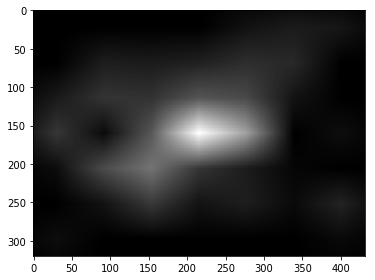

In [5]:
# 画热图
cam_max = np.maximum(cam, 0)                         
cam_normal = cam_max / np.max(cam_max)               
cam3 = resize(cam_normal,(img_height,img_width))
io.imshow(cam3)

# 2 检测热图位置

[ 95  95  95 ... 245 246 246]
[216 217 218 ... 156 153 154]
95 246
81 314


C:\Users\l\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\l\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


True

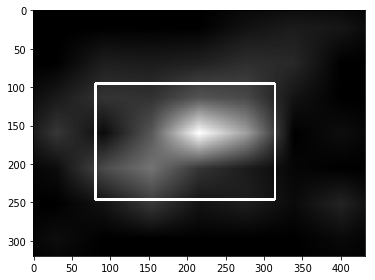

In [6]:
# 对热图画框
threshhold = 0.25
cam3_max = np.max(cam3)
cam3_min = cam3_max * threshhold

position = np.where(cam3 > cam3_min)
min_row,max_row = np.min(position[0]),np.max(position[0])
min_col,max_col = np.min(position[1]),np.max(position[1])
print(position[0])
print(position[1])
print(min_row,max_row)
print(min_col,max_col)

left = min_col
top =  min_row  
right = max_col 
bottom = max_row  

cam3_image = Image.fromarray(cam3)                    
draw = ImageDraw.Draw(cam3_image)                                 
draw.line([(left, top), (left, bottom), (right, bottom),(right, top),(left,top)], width=3)

cam_image = np.array(cam3_image)
io.imshow(cam_image)
cv2.imwrite('./out_image/test1_cam.jpg',cam_image)


# 3 分类

In [7]:
# 加载分类模型  
PATH_TO_CLASSIFY_PB = './detection_models/vehicle_inception_v4_freeze.pb'    
PATH_TO_CLASSIFY_LABELS = './detection_models/labels.txt'   
CLASSIFY_NUM_CLASSES = 764

def preprocess_for_eval(image, height, width,central_fraction=0.875, scope=None):
    with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)            
        if central_fraction:
            image = tf.image.central_crop(image, central_fraction=central_fraction)
        if height and width:
            image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width],align_corners=False)
            image = tf.squeeze(image, [0])            
        image = tf.subtract(image, 0.5)
        image = tf.multiply(image, 2.0)      
        return image

# 分类
classify_graph = tf.Graph()
with classify_graph.as_default():        
    with open(PATH_TO_CLASSIFY_PB, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        
    image_file = tf.read_file(image_path)
    image_decode = tf.image.decode_jpeg(image_file)
    image_preprocessed = preprocess_for_eval(image_decode, 299, 299)    
    with tf.Session(graph=classify_graph) as sess:
        image_input = sess.run(image_preprocessed)
        image_np_expanded = np.expand_dims(image_input,axis=0)
        softmax_tensor = sess.graph.get_tensor_by_name('InceptionV4/Logits/Predictions:0')
        predictions = sess.run(softmax_tensor, feed_dict={'input:0': image_np_expanded})

In [8]:
def classification_box_accuracy(predictions):
    vehicle_label = {} 
    with open(PATH_TO_CLASSIFY_LABELS,encoding='utf-8') as f:
        for item in f.readlines():
            item = item.strip().split(':')
            vehicle_label[int(item[0])] = {'id':int(item[0]),'name':item[1]}

    vehicle_accuracy = np.max(predictions,axis=1)
    vehicle_idx = np.argmax(predictions,axis=1)  
    vehicle_predict_name = []
    for i,idx in enumerate(vehicle_idx):
        if vehicle_accuracy[i] > 0.3:
            vehicle_predict_name = (str(vehicle_label[idx]['name']) + ': ' + '%.1f'%(vehicle_accuracy[i]*100) + '%')
            
    return vehicle_predict_name 

vehicle_predict_name = classification_box_accuracy(predictions)
print(vehicle_predict_name)

三菱-GC-PHEV: 100.0%


# 4  标出汽车位置和型号

C:\Users\l\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\l\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\l\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


True

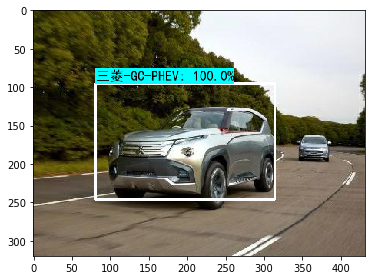

In [9]:
image_with_box = Image.fromarray(imresize(test_image,(img_height,img_width)))          
draw = ImageDraw.Draw(image_with_box)                                 
draw.line([(left, top), (left, bottom), (right, bottom),(right, top),(left,top)], width=3)

try:
    font = ImageFont.truetype('simhei.ttf',18,encoding='utf-8')  # 字体在C:\Windows\Fonts
except IOError:
    font = ImageFont.load_default()

text_width, text_height = font.getsize(vehicle_predict_name)  
text_bottom = top

margin = np.ceil(0.05 * text_height)
draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width,text_bottom)],fill='cyan')
draw.text( (left + margin, text_bottom - text_height - margin),
            vehicle_predict_name,
            fill='black',
            font=font)

img_box_name = np.array(image_with_box)
io.imshow(img_box_name)
cv2.imwrite('./out_image/test1_with_label.jpg',img_box_name)